# Stock Predictive Model
## Goal 

* The primary goal is to build a machine learning model that can predict if a stock's price is likely to go up given the variables of fundamentals data. I am tackling this as a binary classification problem in that we predict either the next year price is likely to go up or not.










## Dataset

- ***New York Stock Exchange S&P 500 companies historical prices with fundamental data***

- URL: https://www.kaggle.com/dgawlik/nyse
- There are 4 csv files in this dataset
    * Fundamentals - fundamentals data for S&P 500 companies from 2011 - 2016
    * Prices - Daily prices from 2011 - 2016 for the same companies
    * Split-Adjusted Prices - Prices data as above but adjusted for shares splits
    * Securities - Company information including company name, sector, address 
   

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Allow plots to appear in the notebook.
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

In [11]:
# Get all data
fundamentals = pd.read_csv('fundamentals.csv')
prices = pd.read_csv('prices-split-adjusted.csv') # we will use the split-adjusted price for better prediction 
securities = pd.read_csv('securities.csv')


In [12]:
#Some helper functions
def lowercase_with_underscore_header(df):
    '''This function will replace the space in the column labels with underscore
       and convert all letters to lowercase
    '''
    underscore_labels = {label:label.replace(' ','_').lower() for label in df.columns} 
    return df.rename(columns = underscore_labels)


In [13]:
# Let's see the fundamentals data
print(fundamentals.shape)
fundamentals.head()

(1781, 79)


,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [14]:
# Drop the first column since it's useless
fundamentals.drop(labels='Unnamed: 0', inplace=True, axis=1)

# Standardize the column labels usning the helper function we created so it's easier to reference the columns
fundamentals =lowercase_with_underscore_header(fundamentals) 

# Crate a year column named 'year' for later on merge
# I want to keep the 'for_year' column as float type for later on use
fundamentals['year'] = fundamentals.period_ending.str[:4]


In [15]:
# Headers look better now
fundamentals.head() 

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add'l_income/expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,total_current_liabilities,total_equity,total_liabilities,total_liabilities_&_equity,total_revenue,treasury_stock,for_year,earnings_per_share,estimated_shares_outstanding,year
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08,2012
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08,2013
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08,2014
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08,2015
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07,2012


In [16]:
# Now let's take a look at the prices data
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [17]:
# Here we need to tie the prices to the fundamentals dataset
# Since the prices data is daily but the fundamentasls is yearly, I am converting the price to annaul by just using the mean

prices['price_year'] = prices.date.str[:4] # add a column called 'price_year'

# group by symbol and year
yearly_prices = prices.groupby(['symbol','price_year']).close.mean().reset_index()

#let's pick IBM and check 
yearly_prices[yearly_prices['symbol']=='IBM']

,symbol,price_year,close
1593,IBM,2010,131.865238
1594,IBM,2011,170.924285
1595,IBM,2012,196.590959
1596,IBM,2013,194.148770
1597,IBM,2014,182.304127
1598,IBM,2015,155.351944
1599,IBM,2016,150.514921


In [18]:
# Now we can merge fundamentals and prices and name it master

master = fundamentals.merge(yearly_prices, 
                            left_on=['ticker_symbol', 'year'],
                            right_on=['symbol', 'price_year'],
                            how='inner' # use inner join becasue I don't need the ones without price
                            )
master.rename(columns={'close':'yearly_price'}, inplace=True) # change the name for the price 

In [19]:
# Now the last file - securities. 
securities.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [20]:
# I am only interested in the GICS Sector and sub industry. Confirm if we have all data populated
securities.isnull().sum()

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64

In [21]:
# Good. looks like there is not much work we need to do with the securites data,  
# Simply just merge this to the master file 

master = master.merge(securities, 
                      left_on='ticker_symbol',
                      right_on='Ticker symbol',
                      how='left'
                     )

master.drop(labels='Ticker symbol', inplace=True, axis=1) # drop dupe ticker column
master = lowercase_with_underscore_header(master) # convert the column labels for evertying again


In [22]:
# Just double check we are not missing the price data
master.yearly_price.isnull().sum()

0

In [23]:
# Now we are done with merging all three files. Time for some feature engineering
# Make a column for PE ratio which is price devided by earning per share

master['pe_ratio'] = master.yearly_price/master.earnings_per_share  


In [24]:
# Ok, here we have a problem...
# The actual values of most fundamentals variables actually are not really useful
# Because we cannot perform individual ticker level prediction given the limited amount of data per ticker
# I need to standardize the values, making them comparable across tickers
# The way to do this is I will use the year-over-year growth rate for all measures that are numeric

# there must be some other way to do this more efficiently but I will go with this fucntion for now 
# since performance is not the primary concern right now
def get_yoy_rate(df, feature, ticker, year):
    '''get year-over-year rate
    
     Args:
         df(pandas DataFrame instance): your dataframe obj. Needs to have columns ['for_year','ticker_symbol','your_feature']
         feature(str): feature/column name. Values for the feature must be numeric. Can only take one feature
         ticker(str): target ticker
         year(int): target year
         
     Returns:
         year-over-year growth rate (float)
         
    '''
    if isinstance(year,(int, float)): # by pass if year is not available
        last_year_value = df[feature][(df['for_year'] == year - 1) & (df['ticker_symbol'] == ticker)].values 
        if last_year_value and isinstance(last_year_value[0],(float, int)): # if value is not numeric then do nothing (return None)
            current_year_value = df[feature][(df['for_year'] == year) & (df['ticker_symbol'] == ticker)].values[0]
            return float(current_year_value - last_year_value[0]) / last_year_value[0] 


In [25]:
# Writing a for loop and tranform everything into growth rate
# Note apprently this will take a good amount of time so I will save the reuslt as a csv file named 'master_yoy.csv'
# uncomment the following codes if need to reproduce the result

"""
yoy_data_arr = []
for col in master.columns:
    yoy_list = []
    for index, row in master.iterrows():
        ticker = row['ticker_symbol']
        year = row['for_year']
        yoy_list.append(get_yoy_rate(master, col, ticker, year))
    yoy_data_arr.append(yoy_list)
    
# transpose the data and assign the column names
_transposed = pd.DataFrame(yoy_data_arr).transpose()
column_names_map = {index:name for index, name in enumerate(master.columns)}
yoy_data = _transposed.rename(columns=column_names_map)

# for columns that do not have numertical values, replace with the original values
temp_series = yoy_data.sum().isnull()
non_numeric_cols = temp_series[temp_series==True].index
for each_col in non_numeric_cols: 
    yoy_data[each_col] = master[each_col]

# save as csv so I don't have to do this again
yoy_data.to_csv('master_yoy.csv')
"""

"\nyoy_data_arr = []\nfor col in master.columns:\n    yoy_list = []\n    for index, row in master.iterrows():\n        ticker = row['ticker_symbol']\n        year = row['for_year']\n        yoy_list.append(get_yoy_rate(master, col, ticker, year))\n    yoy_data_arr.append(yoy_list)\n    \n# transpose the data and assign the column names\n_transposed = pd.DataFrame(yoy_data_arr).transpose()\ncolumn_names_map = {index:name for index, name in enumerate(master.columns)}\nyoy_data = _transposed.rename(columns=column_names_map)\n\n# for columns that do not have numertical values, replace with the original values\ntemp_series = yoy_data.sum().isnull()\nnon_numeric_cols = temp_series[temp_series==True].index\nfor each_col in non_numeric_cols: \n    yoy_data[each_col] = master[each_col]\n\n# save as csv so I don't have to do this again\nyoy_data.to_csv('master_yoy.csv')\n"

In [26]:
# ok we will start with a fresh engineered data here
# Notice, everything now is in year-over-year rate
master_yoy = pd.read_csv('master_yoy.csv')
master_yoy.head()


,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add'l_income/expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,price_year,yearly_price,security,sec_filings,gics_sector,gics_sub_industry,address_of_headquarters,date_first_added,cik,pe_ratio
0,AAL,12/31/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012,NaN,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/2015,6201,NaN
1,AAL,12/31/2013,0.621578,-0.581081,0.388577,1.913043,0.649364,1.256017,0.415094,0.635338,...,2013,0.732818,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/2015,6201,-0.137442
2,AAL,12/31/2014,-0.061709,0.720430,-0.944914,1.134328,0.705523,0.428909,-0.200000,-0.187126,...,2014,1.140081,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/2015,6201,-6.989032
3,AAL,12/31/2015,0.092973,-3.200000,3.720000,-0.055944,0.158162,-0.234159,-0.150000,-0.386312,...,2015,0.159246,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",3/23/2015,6201,-0.590854
4,AAP,12/29/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012,NaN,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/2015,1158449,NaN


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


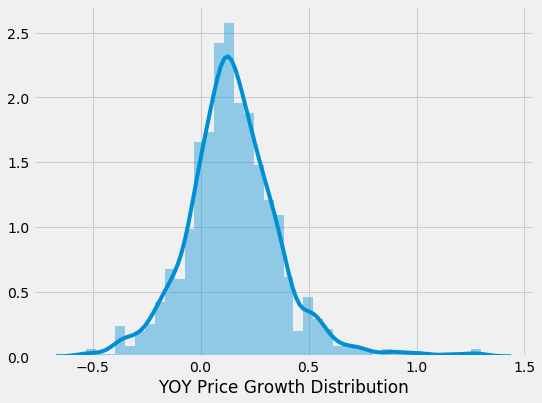

In [27]:
# Just pick one feature and check the distribution
# now it does look pretty centralized
data = master_yoy[['yearly_price']]
sns.distplot(data.dropna(), axlabel='YOY Price Growth Distribution')

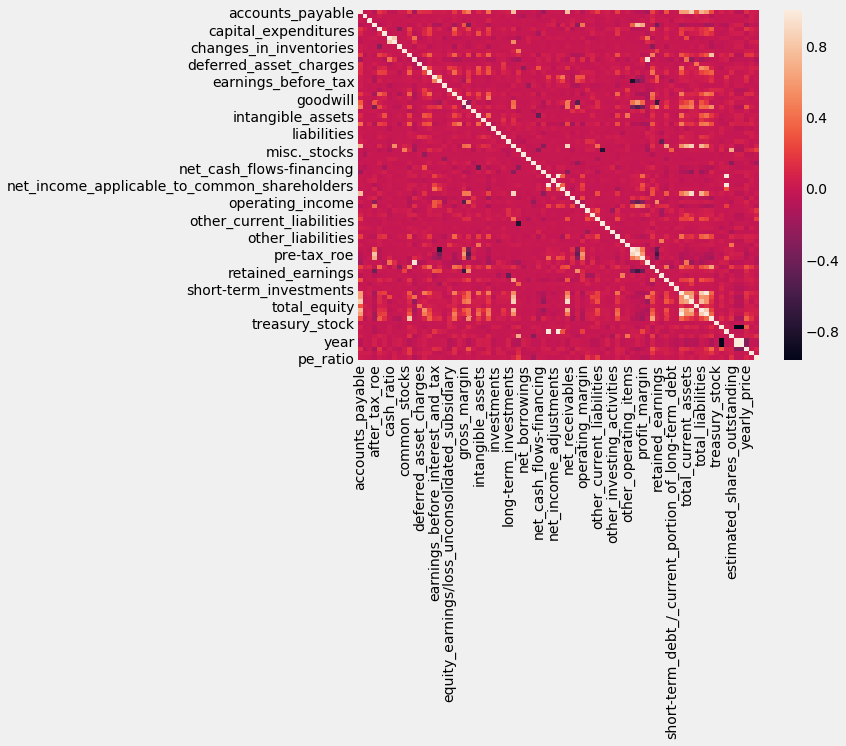

In [28]:
# See the correlation matrix just to get a sense
sns.heatmap(master_yoy.corr())

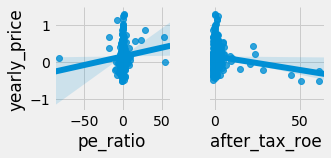

In [29]:
# plot to see the pe ratio vs certain features for top 10 companies
# multiple scatterplots in Seaborn

feature_cols = ['pe_ratio','after_tax_roe']
sns.pairplot(master_yoy, x_vars=feature_cols, y_vars='yearly_price',kind='reg')


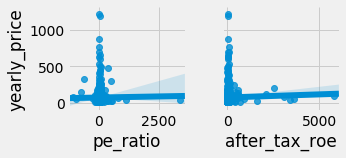

In [30]:
# compare to the original (prior to the yoy transormation), the transformation does make more sense
sns.pairplot(master, x_vars=feature_cols, y_vars='yearly_price',kind='reg')

In [31]:
# now a bit more exploratory with the non-numerical data
# First check the largest sectors
master_yoy.gics_sector.value_counts()

Consumer Discretionary         311
Industrials                    246
Information Technology         234
Financials                     199
Health Care                    191
Consumer Staples               128
Energy                         122
Real Estate                    108
Utilities                       96
Materials                       94
Telecommunications Services     20
Name: gics_sector, dtype: int64

In [32]:
# The goal here is to find out if sector is attributable to the variables
# Let's try the Consumer Discretionary sector
consumer_disc = master_yoy[master_yoy.gics_sector=='Consumer Discretionary']

# Get the correlation
consumer_disc_corr = consumer_disc.corr()[['yearly_price']].sort_values(by=['yearly_price'], ascending=False)
consumer_disc_corr.head(10)

# Ignore the for_year as it does not make sense


,yearly_price
yearly_price,1.000000
for_year,0.389317
common_stocks,0.369805
gross_profit,0.299871
total_revenue,0.294673
accounts_payable,0.264436
net_cash_flow-operating,0.231454
net_receivables,0.215696
"sales,_general_and_admin.",0.214221
capital_expenditures,0.199775


In [33]:
# What about Industrials?
consumer_disc = master_yoy[master_yoy.gics_sector=='Industrials']
consumer_disc_corr = consumer_disc.corr()[['yearly_price']].sort_values(by=['yearly_price'], ascending=False)
consumer_disc_corr.head(10)

# hmm, not quite the same as Consumer Discretionary, as we can see the correlation order on other features changed
# So it appears that the Sector does make some difference here

,yearly_price
yearly_price,1.000000
misc._stocks,0.902549
gross_profit,0.560156
total_revenue,0.474557
research_and_development,0.399668
for_year,0.388397
capital_expenditures,0.359367
estimated_shares_outstanding,0.332368
accounts_payable,0.303950
other_equity,0.298279


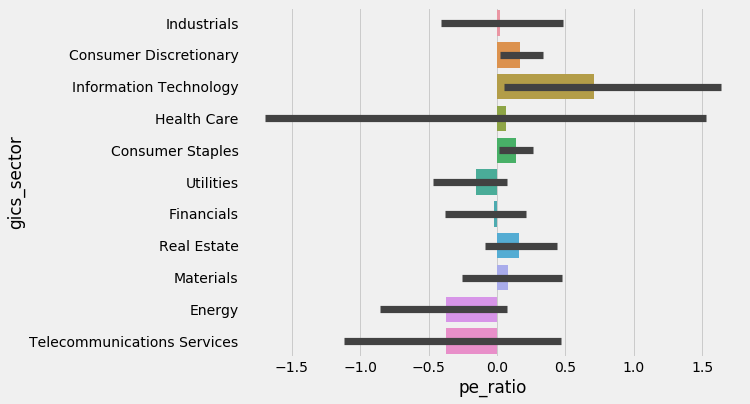

In [34]:
# Would be also intersting to see the pe ratio distribution by the sectors
sns.barplot(data=master_yoy, x='pe_ratio',y='gics_sector')

# So it looks like 'informtion technology' grows the most - which makes sense!

In [35]:
# With what we dicovered, I'd like to make the sectors my features too
# Create dummies features
sector_dummies = pd.get_dummies(master_yoy.gics_sector, prefix='sector')

# Drop the last column - I still want to be able to see the biggest sector 
sector_dummies.drop(sector_dummies.columns[-1], axis=1, inplace=True)

In [36]:
sector_dummies.head()

,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Telecommunications Services
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [37]:
# Concatenate the dummies to the master
master_with_dummies = pd.concat([master_yoy, sector_dummies], axis=1)
# Make the column names consistent
master_with_dummies = lowercase_with_underscore_header(master_with_dummies)
master_with_dummies.head()

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add'l_income/expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,sector_consumer_discretionary,sector_consumer_staples,sector_energy,sector_financials,sector_health_care,sector_industrials,sector_information_technology,sector_materials,sector_real_estate,sector_telecommunications_services
0,AAL,12/31/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,AAL,12/31/2013,0.621578,-0.581081,0.388577,1.913043,0.649364,1.256017,0.415094,0.635338,...,0,0,0,0,0,1,0,0,0,0
2,AAL,12/31/2014,-0.061709,0.720430,-0.944914,1.134328,0.705523,0.428909,-0.200000,-0.187126,...,0,0,0,0,0,1,0,0,0,0
3,AAL,12/31/2015,0.092973,-3.200000,3.720000,-0.055944,0.158162,-0.234159,-0.150000,-0.386312,...,0,0,0,0,0,1,0,0,0,0
4,AAP,12/29/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [38]:
# Here we have a caviet,
# Since we are trying to predict "if the Next Year Price will the go up", 
# We should indicate if next year is going up or not

# Essntially we are just shifting down the growth rate, e.g., 2012 will take 2013's value, 2016 becomes NA
for_next_year_growth = list(master_with_dummies['yearly_price'][1:]) # shift one down 
for_next_year_growth.append(None) # append a nan in the end 


In [39]:
# Create the 'price_go_up' column using the shifted growth rate
master_with_dummies['price_go_up'] = for_next_year_growth

# remove the rows that is null 
master_with_dummies.dropna(subset=['price_go_up'], inplace=True)

In [40]:
# We also have to drop the first year for all tickers since we are missing all the features (remember it's growth rate)
# I know..the downside is we will cut a lot of rows but I just want to have useful data
new_list = []
last_ticker = None
for row in master_with_dummies.values:
    ticker = row[0]
    if ticker == last_ticker:
        new_list.append(row)
        
    last_ticker = ticker

master_with_dummies_final = pd.DataFrame(new_list, columns=master_with_dummies.columns )

In [41]:
# As long as the price growth rate is greater than 0, mark it as 1. Otherwise 0
# Make another column for this binary class
master_with_dummies_final['class_price_go_up'] = (master_with_dummies_final['price_go_up'] > 0).map({True:1, False:0})


In [42]:
# let's take a look
master_with_dummies_final.head()

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add'l_income/expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,sector_energy,sector_financials,sector_health_care,sector_industrials,sector_information_technology,sector_materials,sector_real_estate,sector_telecommunications_services,price_go_up,class_price_go_up
0,AAL,12/31/2013,0.621578,-0.581081,0.388577,1.913043,0.649364,1.256017,0.415094,0.635338,...,0,0,0,1,0,0,0,0,1.140081,1
1,AAL,12/31/2014,-0.061709,0.720430,-0.944914,1.134328,0.705523,0.428909,-0.200000,-0.187126,...,0,0,0,1,0,0,0,0,0.159246,1
2,AAP,12/28/2013,0.082918,-0.637603,3.496667,-0.187500,-0.278134,0.021295,0.739130,0.859974,...,0,0,0,0,0,0,0,0,0.920514,1
3,AAP,1/3/2015,0.385859,0.486647,0.146034,-0.038462,0.166988,0.059575,-0.925000,-0.905911,...,0,0,0,0,0,0,0,0,-0.049858,0
4,AAPL,9/27/2014,0.343042,2.310416,-0.152249,0.166667,0.172198,NaN,-0.569892,-0.029104,...,0,0,0,0,1,0,0,0,0.301040,1


In [44]:
# Now we are finally almost ready to start building the model 
# But we still have a lot of features (80+). How do I select the features so to make the model less complex?
# Well I'll start with getting a set of top 5 corelated features from each sector
num_feature_from_each_sector = 5
# Get the feature columns first
orig_features = list(master_with_dummies_final.columns[2:78]) # Get the original fundamentals features 
orig_features = orig_features + ['pe_ratio'] # need to add this pe_ratio

feature_cols = master_with_dummies_final[orig_features]

sector_set = set([]) # Initiate a set object
for each_sector in master_with_dummies_final.gics_sector.unique():
    sector_df = master_with_dummies_final[master_with_dummies_final.gics_sector==each_sector]
    sector_corr = sector_df.corr()[['price_go_up']].sort_values(by=['price_go_up'], ascending=False) # Get the correlations for earch sector 
    sector_set.update(set(sector_corr.head(num_feature_from_each_sector).index)) # add the top 5 to my set
    
# Take a look
print('Count of feature:',len(sector_set))
sector_set

Count of feature: 23


{'changes_in_inventories',
 'class_price_go_up',
 'effect_of_exchange_rate',
 'equity_earnings/loss_unconsolidated_subsidiary',
 'for_year',
 'goodwill',
 'gross_margin',
 'income_tax',
 'long-term_investments',
 'misc._stocks',
 'net_cash_flow-operating',
 'non-recurring_items',
 'operating_income',
 'operating_margin',
 'other_operating_items',
 'price_go_up',
 'research_and_development',
 'short-term_investments',
 'total_current_assets',
 'total_equity',
 'total_liabilities_&_equity',
 'treasury_stock',
 'yearly_price'}

In [45]:
# Remove the features that I don't want because they are dupes
sector_set.remove('class_price_go_up')
sector_set.remove('price_go_up')
sector_set.remove('yearly_price')
sector_set.remove('for_year')

In [46]:
# ok I will go with these features for now plus the sector dummies that I just created
sector_col_names = [i for i in master_with_dummies.columns if i[:6]=='sector']
feature_cols = list(sector_set) + sector_col_names

In [47]:
# Finally we can start building the model - first I am trying logisic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = master_with_dummies_final[feature_cols].fillna(0) # filling zero for all the mssing data
y = master_with_dummies_final['class_price_go_up']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test) # get the probabilities as well
score = logreg.score(X_test,y_test)
print 'Accuracy Score:', score

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Accuracy Score:', score)? (<ipython-input-47-faec6c2bca81>, line 15)

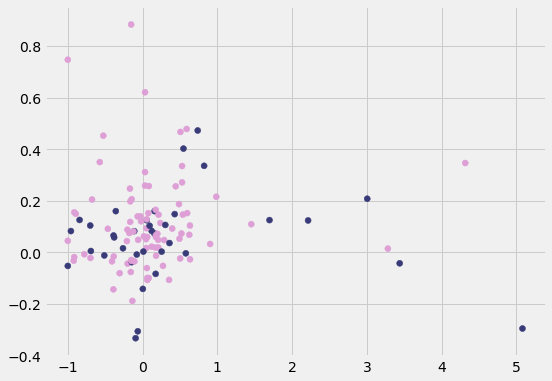

In [48]:
# Plotting some features just to see if we can identify some pattern
plt.scatter(master_with_dummies_final['short-term_investments'],
            master_with_dummies_final['research_and_development'], 
            c=master_with_dummies_final['class_price_go_up'],
            cmap='tab20b'
            )


In [49]:
# This time, try to use all features to build the model
orig_features = list(master_with_dummies_final.columns[2:78]) # Get the original fundamentals features 
orig_features = orig_features + ['pe_ratio'] # need to add this pe_ratio
orig_features = orig_features + sector_col_names # and the sector dummy columns

In [51]:
# Try all features..
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = master_with_dummies_final[orig_features].fillna(0) # filling zero for all the mssing data
y = master_with_dummies_final['class_price_go_up']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test) # get the probabilities as well
score = logreg.score(X_test,y_test)
print('Accuracy Score:', score)

Accuracy Score: 0.7457627118644068


In [54]:
# Try cross validation with 5 folds

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

def show_cross_validation(X,y,k_fold=5):
    print('--------------THIS IS THE K-FOLD----------------------\n')
    K = k_fold
    print('K:', K)
    model = LogisticRegression()

    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=K)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

    # Make cross-validated predictions
    predictions = cross_val_predict(model, X, y, cv=K)
    #print 'Crodd-validated predictions', predictions
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R2:", r2)

In [55]:
show_cross_validation(X,y)

--------------THIS IS THE K-FOLD----------------------

K: 5
Cross-validated scores: [0.73426573 0.70422535 0.67375887 0.72340426 0.70212766]
Mean CV R2: 0.7075563733040509
Std CV R2: 0.02072381969167171
Cross-Predicted R2: -0.5308987590356411


In [57]:
# The confusion metrics 
# Let me get the probability predictions.
logreg_pred_proba = logreg.predict_proba(X_test)[:,1]
cm = metrics.confusion_matrix(y_true=y_test, y_pred=logreg_pred_proba > .5)
TN, FP, FN, TP = cm.flatten()
total = cm.flatten().sum()
acutal_positive = y_test.sum()
actual_negative = total - acutal_positive
accuracy = float(TP+TN)/total
TPR = float(TP)/acutal_positive
FPR = float(FP)/actual_negative
print('Accuracy:', accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

Accuracy: 0.7457627118644068
TPR: 0.9117647058823529
FPR: 0.8048780487804879


In [58]:
# The False positive rate is way to high.. this time I want to change how we define "price go up"
# ie, if price growth rate is greater than x (x % increase), mark it as 1. Otherwise 0

# Create a function so I can easily reproduce the dataset
from sklearn.model_selection import train_test_split
def train_split_model(data, features, increase_by=0):
    '''dynamically create train-split given the threshold'''
    X = data[features].fillna(0) 
    y = (master_with_dummies_final['price_go_up'] > increase_by).map({True:1, False:0})
    return train_test_split(X, y, random_state=10)

In [60]:
# Retrain the model
# Use 20% growth rate 
X_train, X_test, y_train, y_test = train_split_model(master_with_dummies_final, orig_features, increase_by=0.20)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test) # get the probabilities as well
score = logreg.score(X_test,y_test)
print('Accuracy Score:', score)

Accuracy Score: 0.6892655367231638


In [61]:
show_cross_validation(X,y)

--------------THIS IS THE K-FOLD----------------------

K: 5
Cross-validated scores: [0.73426573 0.70422535 0.67375887 0.72340426 0.70212766]
Mean CV R2: 0.7075563733040509
Std CV R2: 0.02072381969167171
Cross-Predicted R2: -0.5308987590356411


In [62]:
# baseline score 
1. - y_train.mean()

0.7231638418079096

In [63]:
def get_metrics_by_growth(data, features, clf, threshold=20):
    '''This is useful to quickly retrive the components from confusion metric
       To see the movement for accuracy, TPR, and FPR given the changes of the threshold
       
    Args: data: pandas dataframe 
          features(list): list of the feature names
          clf: sklearn classifier instance
          threshold(int): threshold for growth rate
    
    Returns: A tuple of accuracy, TPR and FPR
    '''
    X_train, X_test, y_train, y_test = train_split_model(data, features, increase_by=float(threshold)/100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob =clf.predict_proba(X_test) # get the probabilities as well
    clf_pred_proba = clf.predict_proba(X_test)[:,1]
    cm = metrics.confusion_matrix(y_true=y_test, y_pred=clf_pred_proba > .5)
    TN, FP, FN, TP = cm.flatten()
    total = cm.flatten().sum()
    acutal_positive = y_test.sum()
    actual_negative = total - acutal_positive
    accuracy = float(TP+TN)/total
    TPR = float(TP)/acutal_positive
    FPR = float(FP)/actual_negative
    return (accuracy, TPR, FPR)

In [65]:
# Logistic regression using 15%
logreg = LogisticRegression()
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, feature_cols, logreg, threshold=15)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

accuracy: 0.632768361581921
TPR: 0.20833333333333334
FPR: 0.0761904761904762


In [66]:
# Logistic regression using 15%
# what if I use all features
logreg = LogisticRegression()
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, orig_features, logreg, threshold=15)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

accuracy: 0.5988700564971752
TPR: 0.1111111111111111
FPR: 0.06666666666666667


In [68]:
# Now try the decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, feature_cols, treeclf, threshold=15)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

accuracy: 0.5988700564971752
TPR: 0.1111111111111111
FPR: 0.06666666666666667


In [70]:
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, orig_features, treeclf, threshold=15)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

accuracy: 0.6101694915254238
TPR: 0.2222222222222222
FPR: 0.12380952380952381


In [71]:
# How about the feature importance? 
pd.DataFrame({'feature':orig_features,
              'importance':treeclf.feature_importances_}).sort_values(by='importance', ascending=False).head(10)

,feature,importance
45,operating_margin,0.226495
73,for_year,0.219218
65,total_assets,0.174118
48,other_current_liabilities,0.123122
81,sector_health_care,0.093061
7,cash_and_cash_equivalents,0.086289
19,fixed_assets,0.077697
57,profit_margin,0.000000
63,short-term_debt_/_current_portion_of_long-term...,0.000000
62,"sales,_general_and_admin.",0.000000


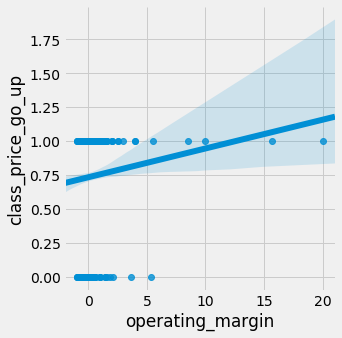

In [72]:
import seaborn as sns

feature_cols = ['operating_margin']
sns.pairplot(master_with_dummies_final, x_vars=feature_cols, y_vars='class_price_go_up',kind='reg', size=5)


In [73]:
important_features = pd.DataFrame({'feature':orig_features,
              'importance':treeclf.feature_importances_}).sort_values(by='importance', ascending=False).head(5)['feature'].values

In [75]:
# Now, let's try the random forest
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=200, max_features=20, oob_score=True, random_state=1)
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, orig_features, rfclf, threshold=20)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

accuracy: 0.7175141242937854
TPR: 0.08
FPR: 0.031496062992125984


In [76]:
# Collect the metrics 
accuracy_list = []
TPR_list = []
FPR_list = []
rfclf = RandomForestClassifier(n_estimators=200, max_features=20, oob_score=True, random_state=1)
for i in range(0, 30, 1):
    accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, orig_features, rfclf, threshold=i)
    accuracy_list.append(accuracy)
    TPR_list.append(TPR)
    FPR_list.append(FPR)

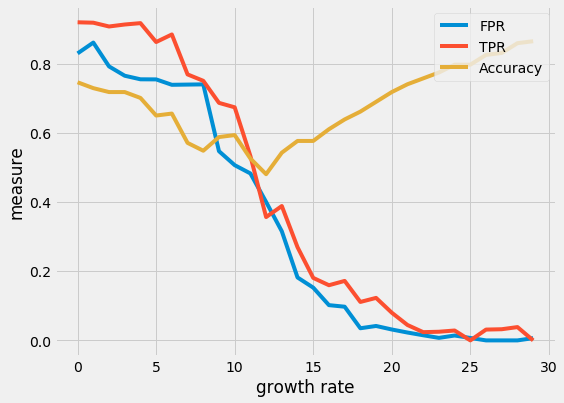

In [77]:
# Plot the chart to see the measures given the growth rate
plt.plot(FPR_list,); # 
plt.plot(TPR_list) # blue line
plt.plot(accuracy_list) 
plt.legend(['FPR', 'TPR', 'Accuracy'], loc='upper right')
plt.xlabel('growth rate');
plt.ylabel('measure');

In [101]:
# I am more concerned about false positive rate than the true positive rate and accuracy
# That is, if I predict a stock that will go up, I want to have high confidence that it will go up
# With that said, I will go with 20%
gowth_rate = 0.2 
y = (master_with_dummies_final['price_go_up'] > gowth_rate).map({True:1, False:0})

In [ ]:
# Now tunning the parameters for n_estimators and number of features
# Use the GridSearchCV
# Get the best n_estimators and max_features
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':range(10,210, 10),
             'max_features':range(5,70)}

rfclf = RandomForestClassifier()
gs = GridSearchCV(estimator=rfclf,
                 param_grid=param_grid,
                 cv=5)
gs.fit(X,y)

In [103]:
# Best estimator 
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=28, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=110, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# Try it out
rfclf = RandomForestClassifier(n_estimators=110, max_features=28, oob_score=True, random_state=1)
accuracy, TPR, FPR = get_metrics_by_growth(master_with_dummies_final, orig_features, rfclf, threshold=20)
print('accuracy:',accuracy)
print('TPR:', TPR)
print('FPR:', FPR)

In [ ]:
# OK, finally I am saving the model
import pickle

rfclf.fit(X_train, y_train)

filename = 'stock_model.pickle'
pickle.dump(rfclf, open(filename, 'wb'))

In [ ]:
# Try loading the model and testing it
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

## Performace Summary
#### The model predicts if a stock price is likely to go up by 20%
#### Overall Accuracy: 73%
#### False positive rate: 1.5%

---
